# Grindelwald bed shape
Since the calibration with only `A` as tuning parameter was not exactly *successful*, I'll have a look at the bed shape. Especially the tounge area my be misrepresented with a non U-shaped bed...

## Import

In [106]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# import OGGM modules
import oggm
from oggm import cfg, graphics, utils
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, massbalance, flowline, inversion

## Initialize

In [107]:
# load default parameter file
cfg.initialize()
# specify working directory
wdir = '/Users/oberrauch/work/grindelwald/working_directories/working_example/'
cfg.PATHS['working_dir'] = wdir

# using intersects
cfg.PARAMS['use_intersects'] = True

# define big border
cfg.PARAMS['border'] = 50

# set climate/massbalance hyper parameters for HistAlp dataset
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-04-10 13:35:52: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


## Preprocessing

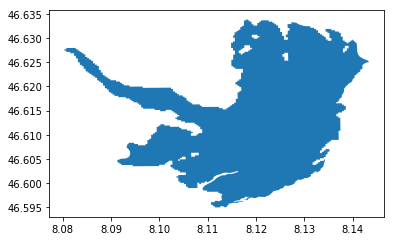

In [108]:
# get RGI entity
rgi_id = 'RGI60-11.01270'
rgi_df = get_rgi_glacier_entities([rgi_id], version='6')
rgi_entity = rgi_df.iloc[0]
rgi_df.plot()

In [109]:
# specify intersects
cfg.set_intersects_db(utils.get_rgi_intersects_region_file('11'))

In [110]:
# prepare glacier directory
gdir = oggm.GlacierDirectory(rgi_entity, reset=True)

### GIS

In [111]:
# GIS tasks
gis.define_glacier_region(gdir, entity=rgi_entity)
gis.glacier_masks(gdir)
gdir

2019-04-10 13:35:54: oggm.core.gis: (RGI60-11.01270) define_glacier_region
2019-04-10 13:35:54: oggm.core.gis: (RGI60-11.01270) glacier_masks


<oggm.GlacierDirectory>
  RGI id: RGI60-11.01270
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 9.023 km2
  Lon, Lat: (8.11933, 46.6143)
  Grid (nx, ny): (192, 183)
  Grid (dx, dy): (52.0, -52.0)

### Centerlines

In [112]:
# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-04-10 13:35:54: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2019-04-10 13:35:55: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2019-04-10 13:35:55: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2019-04-10 13:35:55: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape
2019-04-10 13:35:56: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2019-04-10 13:35:58: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2019-04-10 13:35:58: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2019-04-10 13:35:59: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction


### Climate and mass balance parameters

In [113]:
# process the HistAlp climate file
climate.process_histalp_data(gdir)
climate.local_t_star(gdir)
climate.mu_star_calibration(gdir)

2019-04-10 13:35:59: oggm.core.climate: (RGI60-11.01270) process_histalp_data
2019-04-10 13:36:02: oggm.core.climate: (RGI60-11.01270) local_t_star
2019-04-10 13:36:02: oggm.core.climate: (RGI60-11.01270) local mu* computation for t*=1909
2019-04-10 13:36:02: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


### Mass balance

In [114]:
# istance mass balance model using the historic climate file
mb_model = massbalance.PastMassBalance(gdir)

### Inversion

In [115]:
# run ice thicknes inversion
inversion.prepare_for_inversion(gdir)
inversion.mass_conservation_inversion(gdir)
inversion.filter_inversion_output(gdir)

2019-04-10 13:36:03: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2019-04-10 13:36:03: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2019-04-10 13:36:03: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output


2019-04-10 13:36:03: oggm.core.inversion: (RGI60-11.01270) distribute_thickness_interp
2019-04-10 13:36:03: oggm.core.gis: (RGI60-11.01270) interpolation_masks


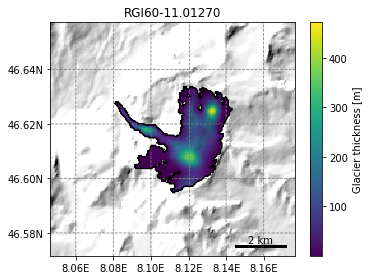

In [116]:
# visualize ice thickness
inversion.distribute_thickness_interp(gdir)
graphics.plot_distributed_thickness([gdir])

### Dynamic model

In [117]:
# finalize the preporcessing
flowline.init_present_time_glacier(gdir)

2019-04-10 13:36:04: oggm.core.flowline: (RGI60-11.01270) init_present_time_glacier


## Flowlines & bed shape

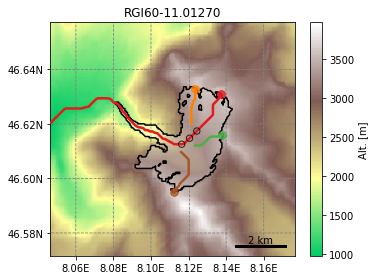

In [118]:
# get flowlines
fls = gdir.read_pickle('model_flowlines')
# view flowlines
graphics.plot_centerlines(gdir, use_model_flowlines=True)

In [82]:
# look at main flowline
fl = fls[-1]
fl.to_dataset()

<xarray.Dataset>
Dimensions:       (c: 2, x: 89)
Coordinates:
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * c             (c) int64 0 1
Data variables:
    linecoords    (x, c) float64 133.0 56.0 132.0 57.73 131.4 59.63 130.0 ...
    surface_h     (x) float64 3.545e+03 3.503e+03 3.446e+03 3.396e+03 ...
    bed_h         (x) float64 3.497e+03 3.455e+03 3.398e+03 3.339e+03 ...
    section       (x) float64 2.654e+04 3.489e+04 5.324e+04 8.101e+04 ...
    bed_shape     (x) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    is_trapezoid  (x) bool True True True True True True True True True True ...
    widths_m      (x) float64 549.3 715.5 1.108e+03 1.41e+03 1.444e+03 ...
    lambdas       (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    class:    MixedBedFlowline
    map_dx:   52.0
    dx:       2.0

In [83]:
pd.DataFrame({'shape': fl.bed_shape, 'rect': fl.is_rectangular, 'lambda': fl._lambdas})

,shape,rect,lambda
0,NaN,True,0.0
1,NaN,True,0.0
2,NaN,True,0.0
3,NaN,True,0.0
4,NaN,True,0.0
5,NaN,True,0.0
6,NaN,True,0.0
7,NaN,True,0.0
8,NaN,True,0.0
9,NaN,True,0.0


In [171]:
line_coords = fl.line.xy
x = np.array(line_coords[0])
y = np.array(line_coords[1])

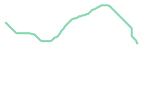

In [129]:
fl.line

(-6.65, 139.65, -96.95, -54.05)

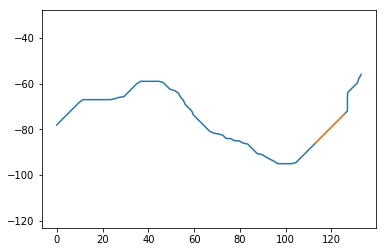

In [172]:
plt.plot(x,-y)
ind0 = 10
ind1 = 20
plt.plot(x[ind0:ind1],-y[ind0:ind1])
plt.gca().axis('equal')

In [179]:
# define frame
xlim = [62, 90]
ylim = [50, 88]
# get indices of points inside frame
ind = (x>xlim[0]) & (x<xlim[1]) & (y>ylim[0]) & (y<ylim[1])

In [189]:
is_trapezoid = fl.is_trapezoid[-1].copy()
is_trapezoid[ind] = True
is_trapezoid

TypeError: 'numpy.bool_' object does not support item assignment

In [180]:
def fl_to_rectangle(fl, ind):
    """ Changes the bed shape of the given indices of the flowline
    into a rectangle. """
    # set bed shape to NaN
    fl.shape
    # set trapezoidal to true
    fl.[ind] = True
    # set lambda to zero
    fl.shape[ind] = np.NaN

array([0.00282884, 0.00224218, 0.00204889, 0.00215583, 0.00257454,
       0.0032477 , 0.00416584, 0.00515606, 0.00632892, 0.00815276,
       0.00935114, 0.01039825, 0.01496422, 0.02615033])

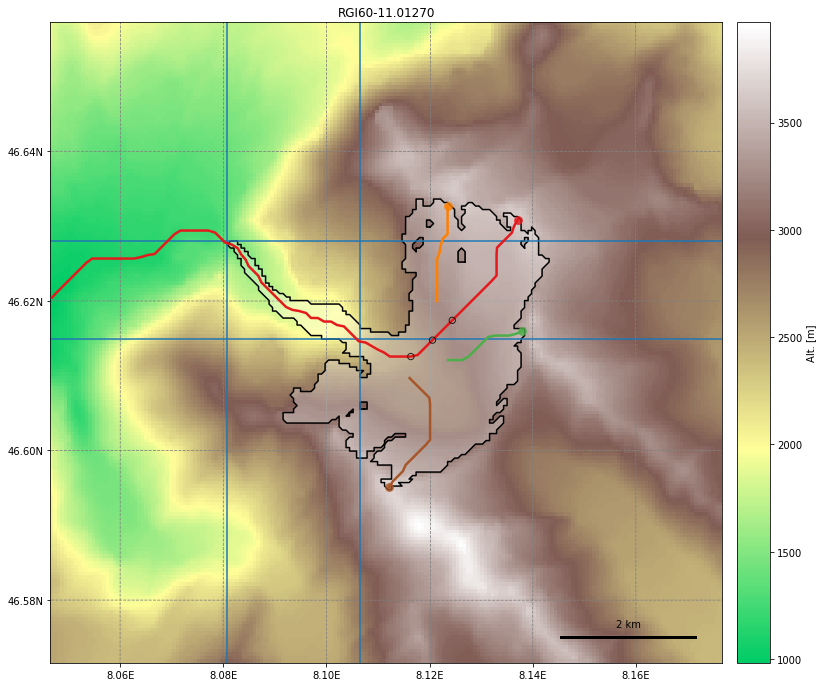

In [152]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_axes([0,0,1,1])
graphics.plot_centerlines(gdir, use_model_flowlines=True, ax=ax)
ax.axhline(62)
ax.axhline(90)
ax.axvline(50)
ax.axvline(88)

## Model

In [29]:
# read needed file
ci =  gdir.read_pickle('climate_info')
fls = gdir.read_pickle('model_flowlines')

In [30]:
# now we can use the flowline model
model = flowline.FluxBasedModel(fls, mb_model=mb_model, glen_a=cfg.PARAMS['glen_a']*factor,
                                y0=ci['baseline_hydro_yr_0'])

In [31]:
# run model over entire HistAlp period
run_ds, diag_ds = model.run_until_and_store(2014)

## Results

In [32]:
# get reference length record info (Leclercq)
leclercq_df = pd.read_csv(get_demo_file('rgi_leclercq_links_2012_RGIV5.csv'))
leclercq_df[leclercq_df.NAME.str.contains('Grindel')]

,LID,RGI_ID,NAME,LON,LAT
48,123,RGI50-11.01270,Ob Grindelwald,8.10,46.62
69,181,RGI50-11.01346,U Grindelwald,8.07,46.58


In [33]:
# get entry for Oberer Grindelwald Gletscher
ob_grindel = leclercq_df[leclercq_df.RGI_ID.str.contains('11.01270')]

# get length index (LID) for the Upper Grindelwald Glacier as DataFrame
index = ob_grindel.LID.values[-1]
index

123

In [34]:
# open the length data file
f = get_demo_file('Glacier_Lengths_Leclercq.nc')
with xr.open_dataset(f) as dsg:
    # the database is not sorted by ID. Don't ask me...
    grp_id = np.argwhere(dsg['index'].values == index)[0][0] + 1
with xr.open_dataset(f, group=str(grp_id)) as ds:
    # read length records
    length_ref = ds.dL.to_dataframe()
    length_ref.columns = ['ref']
    length_ref.name = ds.glacier_name

In [35]:
# get modeled length changes as DataFrame
length_mod = diag_ds.length_m.to_dataframe()[['hydro_year','length_m']]
length_mod = length_mod.reindex(index=length_mod.hydro_year)
length_mod.drop('hydro_year', axis=1, inplace=True)
length_mod.columns = ['mod']

In [36]:
# combine both records
length_df = pd.concat([length_ref, length_mod], axis=1)
# offset reference
length_df.ref += length_df.dropna().diff(axis=1).mean()['mod']

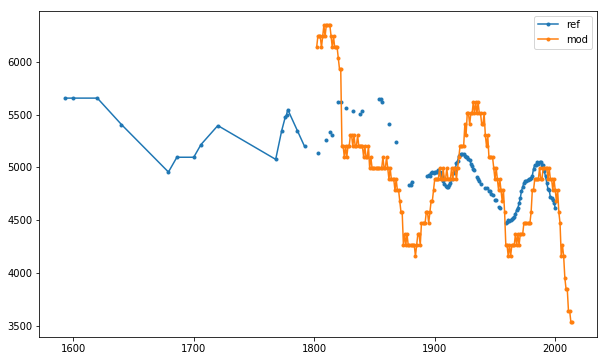

In [37]:
# plot lenght changes
length_df.plot(marker='.', figsize=[10,6])

The amplitude of the modeled length change is too large compared to the reference measurements. However, the temporal correlation seems quite good.

In [38]:
# compute correlation coefficient
length_df.corr()

,ref,mod
ref,1.000000,0.595799
mod,0.595799,1.000000


## More systematic approach
Run the calibration with different values for the creep parameters, i.e. `inversion_glen_a` and `glen_a`. Here are the results...

In [141]:
# read the result of the calibration
calib_res = pd.read_csv('/Users/oberrauch/oggm-fork/oggm/grindel/length_corr.txt', sep=';', index_col=0)
calib_res

,Correlation,RMSD
Factor,,
0.1,0.050440,280.252071
0.2,0.172563,286.433545
0.3,0.323961,291.230146
0.4,0.387674,290.153939
0.5,0.449040,295.595330
0.6,0.465364,294.667509
0.7,0.510887,291.347061
0.8,0.551999,303.766258
0.9,0.574100,307.092063


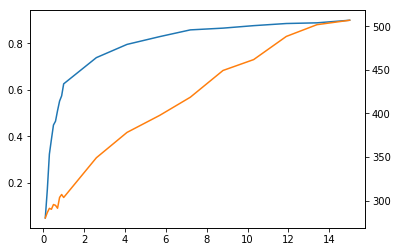

In [121]:
plt.plot(calib_res.Correlation)
ax = plt.gca()
ax = ax.twinx()
ax.plot(calib_res.RMSD, color='C1')

In [158]:
use = calib_res.loc[2.6]
use

Correlation      0.738261
RMSD           349.199585
Name: 2.6, dtype: float64

### Inversion

In [159]:
# run ice thicknes inversion
inversion.prepare_for_inversion(gdir)
inversion.mass_conservation_inversion(gdir, glen_a=cfg.PARAMS['inversion_glen_a'] * use.name)
inversion.filter_inversion_output(gdir)

2019-04-08 15:05:19: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2019-04-08 15:05:20: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2019-04-08 15:05:20: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output


### Dynamic model

In [160]:
# finalize the preporcessing
flowline.init_present_time_glacier(gdir)

2019-04-08 15:05:20: oggm.core.flowline: (RGI60-11.01270) init_present_time_glacier


## Model

In [161]:
# now we can use the flowline model
model = flowline.FluxBasedModel(fls, mb_model=mb_model,
                                glen_a=cfg.PARAMS['glen_a'] * use.name, 
                                y0=ci['baseline_hydro_yr_0'])
# run model over entire HistAlp period
run_ds, diag_ds = model.run_until_and_store(2014)

In [166]:
# get modeled length changes as DataFrame
length_mod = diag_ds.length_m.to_dataframe()[['hydro_year','length_m']]
length_mod = length_mod.reindex(index=length_mod.hydro_year)
length_mod.drop('hydro_year', axis=1, inplace=True)
length_mod.columns = ['model']

# get reference length
from oggm.grindel.utils import get_leclercq_length
length_ref = get_leclercq_length('11.01270')

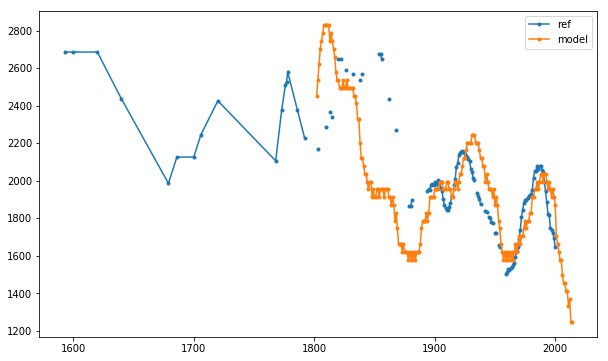

In [170]:
# combine both records
length_df = pd.concat([length_ref, length_mod*0.4], axis=1)
# offset reference
length_df.ref += length_df.dropna().diff(axis=1).mean()['model']

# plot lenght changes
length_df.plot(marker='.', figsize=[10,6])

In [163]:
control = length_df.loc[1894:]
control.corr()

,ref,model
ref,1.000000,0.755531
model,0.755531,1.000000


In [165]:
from oggm.utils import rmsd, rmsd_anomaly
print('RMSD:', rmsd(control.ref, control.model))
print('RMSD anomaly:', rmsd_anomaly(control.ref, control.model))

RMSD: 313.66318523787857
RMSD anomaly: 342.5014065569171
